In [1]:
import os
import numpy as np
import textacy
from spacy.en import English

nlp = English()

In [2]:
class TextPair:
    def __init__(self, author, known, unknown, max_length=1200):
        self.author = author
        self.known = known
        self.unknown = unknown
        self.max_length = max_length

def get_string(filename):
    with open(filename, encoding="utf8") as f:
        s = f.read()
    return s

def get_texts(directory):
    authors = [x for x in os.listdir(directory) if x.startswith("EN")]
    tps = []
    for author in authors:
        known = os.path.join(directory, author, "known01.txt")
        unknown = os.path.join(directory, author, "unknown.txt")
        tps.append(TextPair(author, get_string(known), get_string(unknown)))
    return tps

def get_data(directory):
    # read all texts into known, unknown pairs
    tps = get_texts(directory)
    

    return tps, y

def load_pan_data(directory, prefix="E"):
    """Load known and unknown texts in the PAN data format"""
    # FIXME: assumes one known file per author, which is fine for English datasets only
    authors = sorted([x for x in os.listdir(directory) if x.startswith(prefix)])
    known_texts = []
    unknown_texts = []
    for author in authors:
        kf = os.path.join(directory, author, "known01.txt")
        uf = os.path.join(directory, author, "unknown.txt")
        known_texts.append(read_file(kf))
        unknown_texts.append(read_file(uf))
        
    truthfile = os.path.join(directory, "truth.txt")
    with open(truthfile) as f:
        lines = f.read().strip().split("\n")
    y = [1 if line.split()[1] == "Y" else 0 for line in lines]
    return known_texts, unknown_texts, y

In [3]:
pan15train = "/data/pan15-authorship-verification-training-dataset-english-2015-04-19/"
pan15test = "/data/pan15-authorship-verification-test-dataset2-english-2015-04-19/"
pan14traine = "/data/pan14-author-verification-training-corpus-english-essays-2014-04-22/"
pan14teste = "/data/pan14-author-verification-test-corpus2-english-essays-2014-04-22/"
pan14trainn = "/data/pan14-author-verification-training-corpus-english-novels-2014-04-22/"
pan14testn = "/data/pan14-author-verification-test-corpus2-english-novels-2014-04-22/"

In [4]:
X_train, y_train = get_data(pan15train)
X_test, y_test = get_data(pan15test)

FileNotFoundError: [Errno 2] No such file or directory: '/data/pan15-authorship-verification-training-dataset-english-2015-04-19/'

In [ ]:
with open("glove.840B.300d-char.txt") as f:
    nlp.vocab.load_vectors(f)
    
nlp_word = English()

In [ ]:
def vectorize_distances(tps):
    for i in range(len(tps)):
        tps[i].known = nlp(tps[i].known)
        tps[i].unknown = nlp(tps[i].unknown)
    for i in range(len(tps)):
        w2v = textacy.similarity.word2vec(tps[i].known, tps[i].unknown)
        wm = textacy.similarity.word_movers(tps[i].known, tps[i].unknown)
        jc = textacy.similarity.jaccard(str(tps[i].known), str(tps[i].unknown))
        hm = textacy.similarity.hamming(str(tps[i].known), str(tps[i].unknown))
        jw = textacy.similarity.jaro_winkler(str(tps[i].known), str(tps[i].unknown))
        le = textacy.similarity.levenshtein(str(tps[i].known), str(tps[i].unknown))
        ts = textacy.similarity.token_sort_ratio(str(tps[i].known), str(tps[i].unknown))
        tps[i].distances = [w2v, wm, jc, hm, jw, le, ts]
    return tps


In [ ]:
def vectorize_text(str_text):
    return nlp(str_text, entity=False, tag=False, parse=False).vector
    return np.hstack([nlp(str_text, entity=False, tag=False, parse=False).vector, 
                      nlp_word(str_text, entity=False, tag=False, parse=False).vector])

X_train_known = [vectorize_text(x.known) for x in X_train]
X_train_unknown = [vectorize_text(x.unknown) for x in X_train]
X_test_known = [vectorize_text(x.known) for x in X_test]
X_test_unknown = [vectorize_text(x.unknown) for x in X_test]

In [ ]:
X_train_known[0].shape

In [ ]:
import string
from collections import Counter

def _vectorize(str_text):
    alphabet = string.ascii_lowercase + "!?:;,.'- "
    processed = nlp(str_text, entity=False, tag=True, parse=True)
    stats = textacy.text_stats.TextStats(processed).basic_counts
    s_keys = ['n_long_words', 'n_monosyllable_words', 'n_polysyllable_words', 'n_sents', 
              'n_syllables', 'n_unique_words', 'n_words']
    tag_keys = ['ADJ', 'ADP', 'ADV', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SPACE', 'SYM', 'VERB', 'X']
    tag_keys_set = set(tag_keys)
    
    ratio_stats = [(key, stats[key] / len(str_text)) for key in s_keys]
    
    lower_text_ratios = Counter(''.join(filter(lambda x: x in alphabet, str_text.lower() + alphabet)))
    for key in lower_text_ratios:
        lower_text_ratios[key] /= len(str_text)
    
    lower_text_ratios = [(key, lower_text_ratios[key]) for key in sorted(list(lower_text_ratios.keys()))]

    new_tags = set([word.pos_ for word in processed if word.pos_ not in tag_keys_set])
    if len(new_tags) > 0:
        print(new_tags)
    tags = [word.pos_ for word in processed if word.pos_ in tag_keys_set] + tag_keys
    tag_counter_ratios = Counter(tags)
    for key in tag_counter_ratios:
        tag_counter_ratios[key] /= len(processed)
    
    tag_counter_ratios = [(key, tag_counter_ratios[key]) for key in sorted(list(tag_counter_ratios.keys()))]
    
    return ratio_stats + lower_text_ratios + tag_counter_ratios
        
def vectorize(str_text):
    vecs = _vectorize(str_text)
    return np.array([x[1] for x in vecs])
    
    

In [463]:
X_train_known = [vectorize(x.known) for x in X_train]
X_train_unknown = [vectorize(x.unknown) for x in X_train]
X_test_known = [vectorize(x.known) for x in X_test]
X_test_unknown = [vectorize(x.unknown) for x in X_test]

In [466]:
X_test_known[2].shape

(58,)

In [382]:
set([x[0] for x in test[0]]) - set([x[0] for x in test[1]])

set()

In [ ]:
mean_known = [0] * 7
mean_unknown = [0] * 7
print(mean_known)
for i, p in enumerate(X_train):
    for j, dm in enumerate(p.distances):
        if y_train[i] == 1:
            mean_known[j] += dm
        else:
            mean_unknown[j] += dm
            
    
print(mean_known)
print(mean_unknown)
    

In [ ]:
tr_pairs = [tp.distances for i, tp in enumerate(X_train)]
te_pairs = [tp.distances for i, tp in enumerate(X_test)]

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from statistics import mean
Xs = [X_train_known[i] - X_train_unknown[i] for i in range(len(X_train_known))]
print(mean(cross_val_score(DecisionTreeClassifier(), Xs, tr_y, cv=5)))
# DecisionTreeClassifier().fit(tr_pairs, y_train)
# preds = clf.predict(te_pairs)
# accuracy_score(y_test, preds)

0.48


In [728]:
train_known_X = [x.known.vector for x in X_train]
train_unknown_X = [x.unknown.vector for x in X_train]
test_known_X = [x.known.vector for x in X_test]
test_unknown_X = [x.unknown.vector for x in X_test]

AttributeError: 'str' object has no attribute 'vector'

In [742]:
X_train_known[0]

array([ -5.52522577e-02,   1.74158588e-01,  -1.76483214e-01,
        -8.85840505e-02,   1.29719883e-01,   4.08793986e-02,
         7.86556825e-02,  -1.42121196e-01,  -6.74955696e-02,
         1.69537342e+00,  -2.27257267e-01,   9.35761556e-02,
         7.33497217e-02,  -1.01602666e-01,  -1.77950189e-01,
        -9.79227107e-03,  -5.61515801e-02,   9.61351156e-01,
        -1.39031768e-01,   3.71302739e-02,   5.95916435e-02,
        -1.60850491e-03,  -1.08479774e-02,  -3.60997170e-02,
         2.40866765e-02,   2.02321466e-02,  -1.07352637e-01,
        -3.64199281e-02,   1.56206682e-01,  -9.85744596e-02,
        -5.13009243e-02,   6.27583042e-02,  -5.30031249e-02,
         9.48655531e-02,   6.10492639e-02,  -6.70940615e-03,
         6.48168921e-02,   1.25963047e-01,  -1.00306042e-01,
        -2.60151234e-02,  -1.01310782e-01,  -1.35358749e-02,
         1.89831760e-02,  -8.61115381e-02,   2.78201532e-02,
         1.01727083e-01,  -1.11219011e-01,  -4.65128534e-02,
         5.68935573e-02,

In [540]:
def create_pairs(knownX, unknownX):
    pairs = []
    for i in range(len(knownX)):
        pairs += [[knownX[i], unknownX[i]]]
    pairs = np.array(pairs)
    print(pairs.shape)
    return pairs

In [7]:
tr_pairs = create_pairs(X_train_known, X_train_unknown)
te_pairs = create_pairs(X_test_known, X_test_unknown)

NameError: name 'create_pairs' is not defined

In [63]:
tr_y = y_train
te_y = y_test

shuff_tr_y = tr_y[:]
shuff_te_y = te_y[:]
from random import shuffle
shuffle(shuff_tr_y)
shuffle(shuff_te_y)


In [162]:
truthfile = os.path.join(pan15train, "truth.txt")
with open(truthfile) as f:
    lines = f.read().strip().split("\n")
y = [1 if line.split()[1] == "Y" else 0 for line in lines]
tr_y = np.array(y)

In [755]:
te_y = y_test
tr_y = y_train

In [756]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import random

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(128, input_shape=(input_dim,), activation='relu'))
    seq.add(Dense(128))
    seq.add(Dense(128))
    return seq

def compute_accuracy(predictions, labels):
    return np.mean(np.equal(predictions.ravel() < 0.5, labels))

def train(tr_pairs, tr_y):
    input_dim = tr_pairs.shape[-1]

    # network definition
    base_network = create_base_network(input_dim)

    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
    model = Model(inputs=[input_a, input_b], outputs=distance)
    
    rms = RMSprop()
    model.compile(loss=contrastive_loss, optimizer=rms)
    model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
              validation_split=0.05,
              batch_size=5,
              epochs=35)
    return model
       
def evaluate(model, tr_pairs, tr_y, te_pairs, te_y):
    # compute final accuracy on training and test sets
    pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
    tr_acc = compute_accuracy(pred, tr_y)
    pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
    te_acc = compute_accuracy(pred, te_y)
    print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
    print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

In [554]:
tr_y = y_train
te_y = y_test

print(len(tr_y))

100


In [757]:
model = train(tr_pairs, tr_y)
evaluate(model, tr_pairs, tr_y, te_pairs, te_y)

Train on 95 samples, validate on 5 samples
Epoch 1/35
95/95 [==============================] - 0s - loss: 36.4861 - val_loss: 27.6374
Epoch 2/35
95/95 [==============================] - 0s - loss: 11.6386 - val_loss: 24.1654
Epoch 3/35
95/95 [==============================] - 0s - loss: 5.9530 - val_loss: 21.9502
Epoch 4/35
95/95 [==============================] - 0s - loss: 3.0999 - val_loss: 19.7873
Epoch 5/35
95/95 [==============================] - 0s - loss: 2.0858 - val_loss: 18.7038

In [770]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

In [781]:
preds = [p[0] < 3 for p in pred]
print(Counter(preds))

Counter({True: 261, False: 239})


In [782]:
print(classification_report(te_y, preds))

             precision    recall  f1-score   support

          0       0.55      0.53      0.54       250
          1       0.55      0.57      0.56       250

avg / total       0.55      0.55      0.55       500



array([  0.00000000e+00,  -5.87621488e-01,  -3.52727016e-02,
         2.40195481e-01,   3.94721470e-01,  -1.06242697e+00,
         7.31022365e-01,  -2.89649183e-01,   7.28606111e-01,
         4.39075035e-03,  -2.23961172e-01,  -1.81819105e+00,
         1.35028124e-01,   1.67917742e+00,  -1.22353041e-01,
         2.00387033e+00,  -1.74953262e+00,  -1.07908780e+00,
         1.63199923e-01,   1.72902931e-01,   1.84942456e+00,
         3.19833758e-01,  -1.00543549e+00,  -2.11924821e-01,
         7.11160827e-01,  -5.50484238e-01,  -6.57770024e-01,
        -7.02525449e-01,  -2.09462439e-01,  -5.20386817e-01,
         1.42220669e+00,  -1.22371804e-01,  -5.51757069e-01,
        -7.07106781e-02,  -5.05396701e-01,   1.99894166e+00,
        -2.57893737e-01,  -6.54164816e-01,  -2.94298001e-01,
        -2.20955960e-01,  -4.54488575e-01,   7.97869763e-01,
        -2.77818583e-01,  -9.91059811e-01,  -4.12898283e-01,
        -1.21549384e+00,  -3.52409344e-01,  -5.39199159e-01,
        -2.40239491e-01,

In [60]:
shuff_tr_y

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1])

In [61]:
y_train

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1])

In [5]:
# standard imports
import string
from collections import Counter

# third-party imports
import textacy
from spacy.en import English
from statistics import mean, stdev

def _normalize_counter(counter, c):
    """Divide all the values in a Counter by a constant and remove padding"""
    for key in counter:
        counter[key] = (counter[key] - 1) / c
    return counter

class TextAnalyser:
    def __init__(self, nlp=None, funcwordsfile="function_words.txt"):
        if nlp:
            self.nlp = nlp
        else:
            self.nlp = English()
            
        # alphabet for letter ratios
        self.alphabet = string.ascii_lowercase + "!?:;,.'- "
        self.alphabet = "!?:;,.'- "
        
        # keys that we care about from textacy.stats
        self.basic_keys = ['n_long_words', 'n_monosyllable_words', 'n_polysyllable_words', 'n_sents', 'n_syllables', 'n_unique_words', 'n_words']
        
        # keys that we care about for textacy readability stats
        self.readability_keys = ['automated_readability_index','coleman_liau_index', 'flesch_kincaid_grade_level',
                                 'flesch_readability_ease', 'gulpease_index', 'gunning_fog_index', 'lix',
                                 'wiener_sachtextformel']
        
        # parts of speech that we care about from spacy (pos_ not tag_)
        self.pos_keys = ['ADJ', 'ADP', 'ADV', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SPACE', 'SYM', 'VERB', 'X']
        self.pos_keys_set = set(self.pos_keys)
        
        with open(funcwordsfile) as f:
            s = sorted(f.read().split("\n"))
        self.func_words = s

    def get_named_features(self, text):
        # TODO: Add bigrams, trigrams?
        processed = self.nlp(text, entity=False, tag=True, parse=True)
        stats = textacy.text_stats.TextStats(processed)
        basic_stats = stats.basic_counts
        readability_stats = stats.readability_stats
        cleaned_text = ''.join(filter(lambda x: x in self.alphabet, text.lower() + self.alphabet))
        
        stats_ratios = {key: (basic_stats[key] / len(text)) for key in self.basic_keys}
        readability_ratios = {key: (readability_stats[key] / len(text)) for key in self.readability_keys}
        # stats_ratios.update(readability_ratios)
        

        # get only the characters we care about 
        # append alphabet so that each character artificially appears once
        char_ratios = Counter(cleaned_text)
        char_ratios = _normalize_counter(char_ratios, len(text))

        # calculate pos ratios
        tags = [word.pos_ for word in processed if word.pos_ in self.pos_keys_set] + self.pos_keys
        pos_ratios = Counter(tags)
        pos_ratios = _normalize_counter(pos_ratios, len(processed)) # normalize by word length
        
        word_counts = Counter([word.text.lower() for word in processed])
        func_words = {fword: (word_counts[fword]/len(processed)) for fword in self.func_words}
        
        res = stats_ratios
        res.update(char_ratios)
        res.update(pos_ratios)
        res.update(func_words)
        return [(key, res[key]) for key in sorted(res)]
    
    def calculate_mean_and_std(self, extracted_texts):
        """finds unusual patterns by calculating mean and std deviation for a list of 
           extracted features and sorting by z-score"""
        means = []
        stds = []
        sample = extracted_texts[0]  # get one text for feature size and names
        num_features = len(sample)
        # fi = feature index
        for fi in range(num_features):
            u = mean([stat[fi][1] for stat in extracted_texts])
            o = stdev([stat[fi][1] for stat in extracted_texts])
            means.append((sample[fi][0], u))
            stds.append((sample[fi][0], o))
        return means, stds
    
    def calculate_z_scores(self, extracted_text, means, stds):
        """Calculate the zscores for each features of a single text (extractions)"""
        # z = (X - μ) / σ
        zscores = []
        num_features = len(extracted_text)
        for fi in range(num_features):
            feature_name = extracted_text[fi][0]
            try:
                zscore = (extracted_text[fi][1] - means[fi][1]) / stds[fi][1]
            except ZeroDivisionError:
                zscore = 0
            zscores.append((zscore, feature_name))
        return zscores
        
def vectorize(str_text):
    vecs = _vectorize(str_text)
    return np.array([x[1] for x in vecs])
    
    

In [6]:
def format_unusual_features(zscores, nfeatures=5):
    zscores = sorted(zscores)
    s = ""
    for j in range(nfeatures):
        fname = zscores[j][1]
        padding = " " * (30 - len(fname))
        s += "{} is low {}(zscore: {})\n".format(fname, padding, zscores[j][0])
    s += "    . . .     \n"
    for j in range(nfeatures):
        fname = zscores[-(j + 1)][1]
        padding = " " * (30 - len(fname))
        s += "{} is high{}(zscore: {})\n".format(fname, padding, zscores[-(j + 1)][0])
    return s

def supports_and_opposes(zscores1, zscores2, sup_threshold=1.5):
    supports = []
    opposes = []
    for i in range(len(zscores1)):
        # both are high or low
        if (zscores1[i][0] > sup_threshold and zscores2[i][0] > sup_threshold) or (
            zscores1[i][0] < -sup_threshold and zscores2[i][0] < -sup_threshold):
            supports.append((zscores1[i], zscores2[i]))
        # one is high and the other is low
        if (zscores1[i][0] > sup_threshold and zscores2[i][0] < -sup_threshold) or (
            zscores1[i][0] < -sup_threshold and zscores2[i][0] > sup_threshold):
            opposes.append((zscores1[i], zscores2[i]))
    return supports, opposes 

def shared_top_bottom(zs1, zs2, n=10):
    """Find shared top/bottom n most unusual features between two texts"""
    zs1 = sorted(zs1)
    zs2 = sorted(zs2)
    
    t1, b1 = zs1[-n:], zs1[:n]
    t2, b2 = zs2[-n:], zs2[:n]
    
    shared_top = set([f[1] for f in t1]).intersection(set([f[1] for f in t2]))
    shared_bottom = set([f[1] for f in b1]).intersection(set([f[1] for f in b2]))
    
    opposed1 = set([f[1] for f in t1]).intersection(set([f[1] for f in b2]))
    opposed2 = set([f[1] for f in t2]).intersection(set([f[1] for f in b1]))
    
    return shared_top, shared_bottom, opposed1, opposed2

In [7]:
def get(knowns, unknowns):
    knownstats = [ta.get_named_features(text) for text in knowns]
    unknownstats = [ta.get_named_features(text) for text in unknowns]
    means, stds = ta.calculate_mean_and_std(knownstats + unknownstats)
    knownzs = [ta.calculate_z_scores(ks, means, stds) for ks in knownstats]
    unknownzs = [ta.calculate_z_scores(ks, means, stds) for ks in unknownstats]
    
    preds = []
    for i in range(len(knowns)):
        z1 = knownzs[i]
        z2 = unknownzs[i]
        s, o = supports_and_opposes(z1, z2, sup_threshold=0.4)
        preds.append(len(s) > len(o))
    return preds

preds_train = get(known_train, unknown_train)
preds_test = get(known_test, unknown_test)



NameError: name 'known_train' is not defined

In [600]:
len(known_train)

100

In [604]:
# preds_train = get(known_train, unknown_train)
# preds_test = get(known_test, unknown_test)
print(Counter(preds_train))
print(Counter(preds_test))
# print(classification_report(y_test, preds_test))
# print("---")
print(classification_report(y_test, preds_test))

Counter({True: 85, False: 15})
Counter({True: 411, False: 89})
             precision    recall  f1-score   support

          0       0.74      0.26      0.39       250
          1       0.55      0.91      0.69       250

avg / total       0.65      0.59      0.54       500



In [889]:
knowns, unknowns = known_test, unknown_test
knownstats = [ta.get_named_features(text) for text in knowns]
unknownstats = [ta.get_named_features(text) for text in unknowns]
means, stds = ta.calculate_mean_and_std(knownstats + unknownstats)
knownzs = [ta.calculate_z_scores(ks, means, stds) for ks in knownstats]
unknownzs = [ta.calculate_z_scores(ks, means, stds) for ks in unknownstats]

In [986]:
from scipy.stats import spearmanr

In [1000]:
def get_rhos(knownstats, unknownstats):
    rhos = []
    for i in range(len(knownstats)):
        ks = [s[1] for s in knownstats[i]]
        us = [s[1] for s in unknownstats[i]]
        rhos.append(spearmanr(ks,us))
    return rhos

rhos = get_rhos(knownstats, unknownstats)
rhos = [r[0] for r in rhos]

In [1012]:
knownstats[2]

[('', 0.0),
 (' ', 0.16892289582107123),
 ('!', 0.0005885815185403178),
 ("'", 0.012360211889346674),
 (',', 0.015303119482048263),
 ('-', 0.0),
 ('.', 0.012948793407886992),
 (':', 0.0),
 (';', 0.0017657445556209534),
 ('?', 0.006474396703943496),
 ('ADJ', 0.05454545454545454),
 ('ADP', 0.05),
 ('ADV', 0.125),
 ('CCONJ', 0.011363636363636364),
 ('DET', 0.04772727272727273),
 ('INTJ', 0.01818181818181818),
 ('NOUN', 0.09772727272727273),
 ('NUM', 0.0),
 ('PART', 0.006818181818181818),
 ('PRON', 0.1),
 ('PROPN', 0.10227272727272728),
 ('PUNCT', 0.1431818181818182),
 ('SPACE', 0.07954545454545454),
 ('SYM', 0.0),
 ('VERB', 0.16363636363636364),
 ('X', 0.0),
 ('a', 0.013636363636363636),
 ('about', 0.0),
 ('above', 0.0),
 ('after', 0.0),
 ('all', 0.0),
 ('although', 0.0),
 ('am', 0.0),
 ('among', 0.0),
 ('an', 0.0),
 ('and', 0.004545454545454545),
 ('another', 0.0),
 ('any', 0.0),
 ('anybody', 0.0),
 ('anyone', 0.0),
 ('anything', 0.0),
 ('are', 0.0022727272727272726),
 ('around', 0.0),
 

In [1011]:
knowns[2]

"Tomorrow comes the great, grand\nfestival of Christmas, is it not, Paddy Mike?\n\nSure and it is. This is\nthe holy Christmas Eve.\n\nThe night of the day\nbehind Christmas is always Christmas Eve, ain't it?\nSure it is.\n\nUnd tomorrow we gets lots of Christmas presents always, me\nund Klinker; don't we, Klinker?\n\nSure we do. Leedle horses and pictures und candy und other\nthings also; don't we, Schwillie Willie Winkum?\n\nThat was when we were at home in Holland. It's different,\nmaybe, out here in this great big boat. Ven we get by the city of New\nYork next week then maybe we'll get some presents already.\n\nBut good Saint Nicholas always comes the night before\nChristmas; don't he, Schwillie Willie Winkum?\n\nSure. Won't he come tonight, Hulda?\n\nHow could he get way out here on the ocean already? Do you\nthink he is a fish? We ain't living at home in Holland no more. We're\nway out on the Atlantic Ocean in a great big ship.\n\nJa, und I wish I was back at home already. So muc

In [979]:
all_shared = [shared_top_bottom(knownzs[i], unknownzs[i], 40) for i in range(len(knownzs))]
preds = [(len(all_shared[i][0]) + len(all_shared[i][1]), (len(all_shared[i][2]) + len(all_shared[i][3])))  for i in range(len(all_shared))]
preds = [1 if p[0] > (p[1]+5) else 0 for p in preds]

In [975]:
Counter(preds)

Counter({0: 276, 1: 224})

In [976]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.68      0.75      0.71       250
          1       0.72      0.65      0.68       250

avg / total       0.70      0.70      0.70       500



In [693]:
def read_file(filepath):
    with open(filepath) as f:
        s = f.read()
    return s

known_train, unknown_train, y_train = load_pan_data(pan15train)
known_test, unknown_test, y_test = load_pan_data(pan15test)

In [696]:
ta = TextAnalyser()

In [569]:
def load_all_pan(paths):
    known, unknown, labels = [], [], []
    for path in paths:
        k, u, y = load_pan_data(path)
        known += k
        unknown += u
        labels += y
    return known, unknown, labels

known, unknown, labels = load_all_pan([pan15train, pan15test, pan14traine, pan14teste, pan14trainn, pan14testn])

In [694]:
def get_zscores(knowns, unknowns, means=None, stds=None, ta=None):
    if not ta:
        ta = TextAnalyser()
    knownstats = [ta.get_named_features(text) for text in knowns]
    unknownstats = [ta.get_named_features(text) for text in unknowns]
    if not means:
        means, stds = ta.calculate_mean_and_std(knownstats + unknownstats)
    knownzs = [ta.calculate_z_scores(ks, means, stds) for ks in knownstats]
    unknownzs = [ta.calculate_z_scores(ks, means, stds) for ks in unknownstats]
    return knownzs, unknownzs

In [579]:
knownzs, unkzs, means, stds = get_zscores(known, unknown)

KeyboardInterrupt: 

In [584]:
xk1 = knownzs[:100]
xu1 = unknownzs[:100]
y1 = labels[:100]

In [263]:
s, o = supports_and_opposes(knownzs[11], unknownzs[11], sup_threshold=0.0)

In [578]:
len(x1[0])

NameError: name 'x1' is not defined

In [182]:
same_looks_different = [(i,v) for i,v in enumerate(y_test) if v and not preds_test[i]]

In [184]:
different_looks_same = [(i,v) for i,v in enumerate(preds_test) if v and not y_test[i]]

In [697]:
known_train, unknown_train, y_train = load_pan_data(pan15train)
known_test, unknown_test, y_test = load_pan_data(pan15test)

tr_kzs, tr_uzs = get_zscores(known_train, unknown_train)
te_kzs, te_uzs = get_zscores(known_test, unknown_test)

In [754]:
def top_bottom_shared_preds(kzs, unkzs, n, threshold=0):
    all_shared = [shared_top_bottom(kzs[i], unkzs[i], n) for i in range(len(kzs))]
    preds = [len(all_shared[i][0]) + len(all_shared[i][1]) for i in range(len(all_shared))]
    preds = [1 if p > threshold else 0 for p in preds]
    return preds

tr_preds = top_bottom_shared_preds(tr_kzs, tr_uzs, 1, 0)
te_preds = top_bottom_shared_preds(te_kzs, te_uzs, 1, 0)

print(Counter(tr_preds))
print(Counter(te_preds))

print(classification_report(y_train, tr_preds))
print(classification_report(y_test, te_preds))

Counter({0: 96, 1: 4})
Counter({0: 483, 1: 17})
             precision    recall  f1-score   support

          0       0.52      1.00      0.68        50
          1       1.00      0.08      0.15        50

avg / total       0.76      0.54      0.42       100

             precision    recall  f1-score   support

          0       0.49      0.96      0.65       250
          1       0.35      0.02      0.04       250

avg / total       0.42      0.49      0.35       500



In [799]:
from scipy.spatial import distance
def feature_distance(f1, f2):
    return abs(f1[0] - f2[0])

def absolute_diff_distance(t1, t2):
    return [feature_distance(t1[i], t2[i]) for i in range(len(t1))]

def euclidean_distance(t1, t2):
    return distance.euclidean([f[0] for f in t1], [f[0] for f in t2])

def cosine_distance(t1, t2):
    return distance.cosine([f[0] for f in t1], [f[0] for f in t2])


dist_func = euclidean_distance
X_train_e = [dist_func(tr_kzs[i], tr_uzs[i]) for i in range(len(tr_kzs))]
X_test_e = [dist_func(te_kzs[i], te_uzs[i]) for i in range(len(te_kzs))]

dist_func = cosine_distance
X_train_c = [dist_func(tr_kzs[i], tr_uzs[i]) for i in range(len(tr_kzs))]
X_test_c = [dist_func(te_kzs[i], te_uzs[i]) for i in range(len(te_kzs))]

In [798]:
print(X_train[:10])
print(y_train[:10])

[0.74221908923121727, 0.88056118472560485, 1.0986871933765374, 0.97919885746483071, 1.0351577403508472, 1.0156437632077184, 1.0463419753296597, 1.0695400717547638, 0.9432596803754586, 1.12713696099739]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0]


In [791]:
t1 = [f[0] for f in tr_kzs[0]]
t2 = [f[0] for f in tr_uzs[0]]
print(distance.euclidean(t1, t2))
print(distance.cosine(t1, t2))

14.1702272508127
0.742219089231


In [755]:
def get_values(text):
    return [feature[0] for feature in text]

tr_k = [get_values(t) for t in tr_kzs]
tr_u = [get_values(t) for t in tr_uzs]

te_k = [get_values(t) for t in te_kzs]
te_u = [get_values(t) for t in te_uzs]

tr_pairs = create_pairs(tr_k, tr_u)
te_pairs = create_pairs(te_k, te_u)

(100, 2, 182)
(500, 2, 182)


In [701]:
import statistics

def mean(lst):
    return len([x for x in lst if x > 1]) - len([x for x in lst if x < 0.5])

means = [mean(x) for x in X_train]
thresh = 0.9
preds = [0 if x > thresh else 1 for x in means]
print(Counter(preds))
print(classification_report(y_train, preds))

means = [mean(x) for x in X_test]
thresh = 0.9
preds = [0 if x > thresh else 1 for x in means]
print(Counter(preds))
print(classification_report(y_test, preds))

Counter({1: 100})
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        50
          1       0.50      1.00      0.67        50

avg / total       0.25      0.50      0.33       100

Counter({1: 500})
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       250
          1       0.50      1.00      0.67       250

avg / total       0.25      0.50      0.33       500



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [705]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# X_train, X_test = X_test, X_train
# y_train, y_test = y_test, y_train
clf = LinearSVC()
# clf = MLPClassifier(max_iter=5000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
#
preds = cross_val_predict(clf, X_train, y_train, cv=5)
# print(classification_report(y_train, preds))

# print(cross_val_score(clf, X_train, labels, cv=5))
preds = cross_val_predict(clf, X_test, y_test, cv=5)
# print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.52      0.59      0.55       250
          1       0.52      0.45      0.48       250

avg / total       0.52      0.52      0.52       500



In [706]:
X_train[0]

[0,
 0.015627680469636474,
 0.12235069802681779,
 1.1221632011174523,
 1.7143503619886888,
 2.1979918629116755,
 1.595392130404688,
 0.0,
 0.8380670501940051,
 0.5269208427878804,
 1.1817991707721203,
 0.21598408283409043,
 0.427733274995719,
 2.3347334310683947,
 0.8163466736415038,
 0.858292458136892,
 0.5253221087464783,
 0.0,
 1.506191046746371,
 0.0019864395404885493,
 0.7716184135354678,
 2.663755519453452,
 0.8867395788933928,
 0.0,
 1.203424540727251,
 0.0,
 0.4936650172350138,
 1.1119850134649847,
 0.0,
 0.0,
 1.5191031571369111,
 0.0,
 0.0,
 0.0,
 0.0,
 2.23456900502077,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6058477756918226,
 6.358879316171409,
 0.0,
 0.6204057125871285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.7280938250593202,
 1.3999060849539289,
 3.38142928595038,
 0,
 1.2028304021109149,
 1.3703783106229028,
 2.488463148617295,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.1518918631951436,
 0.0,
 0.7288303927400683,
 2.3831448670841424,
 0.010768164990658843,

In [465]:
preds = []
for i in range(len(tr_kzs)):
    z1 = tr_kzs[i]
    z2 = tr_uzs[i]
    s, o = supports_and_opposes(z1, z2, sup_threshold=1.4)
    preds.append(len(s) > len(o))

In [449]:
Counter(preds)

Counter({False: 577, True: 723})

In [451]:
print(classification_report(labels, preds))

             precision    recall  f1-score   support

          0       0.59      0.52      0.55       650
          1       0.57      0.64      0.60       650

avg / total       0.58      0.58      0.58      1300



In [450]:
mean([ 0.70588235,  0.70588235,  0.5625    ])

0.6580882333333333

In [800]:
np.hstack([y_train,y_test]).shape

(600,)

In [306]:
means = [mean(x) for x in Xs]

In [810]:
true = np.hstack([y_train,y_test])
same = [x for i, x in enumerate(X_test_c) if y_test[i]]
diff = [x for i, x in enumerate(X_test_c) if not y_test[i]]

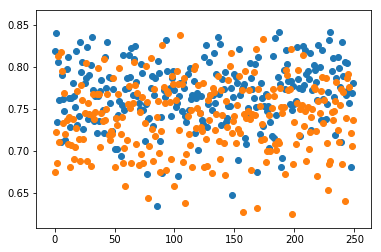

In [1005]:
%matplotlib inline
from matplotlib import pyplot as plt

same = [x for i, x in enumerate(rhos) if y_test[i]]
diff = [x for i, x in enumerate(rhos) if not y_test[i]]
plt.scatter(range(len(same)), same)
plt.scatter(range(len(same)), diff)